# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [2]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           calculate_parameter_sensitivity,
                           plot_parameter_sensitivity,
                           plot_regression_fit)

INFO:myokit:Loading Myokit version 1.27.4


In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create ion channel model

In [5]:
from channels.icat import icat as model
#model.sample({})

# Get experimental measurements

In [6]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [7]:
limits = dict(g_CaT=(0, 2),
              v_offset=(0, 500),
              p1=(0, 100),
              p2=(0, 10),
              p3=(0, 10),
              p4=(0, 10),
              p5=(0, 0.5),
              p6=(0, 500),
              q1=(0, 100),
              q2=(0, 50),
              q3=(0, 50),
              q4=(0, 500),
              q5=(0, 0.5),
              q6=(0, 100))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Parameter sensitivity analysis

In [10]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

In [11]:
parameters = ['icat.'+k for k in limits.keys()]

In [12]:
fitted, regression_fit, r2 = calculate_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.1,
    n_samples=1000)

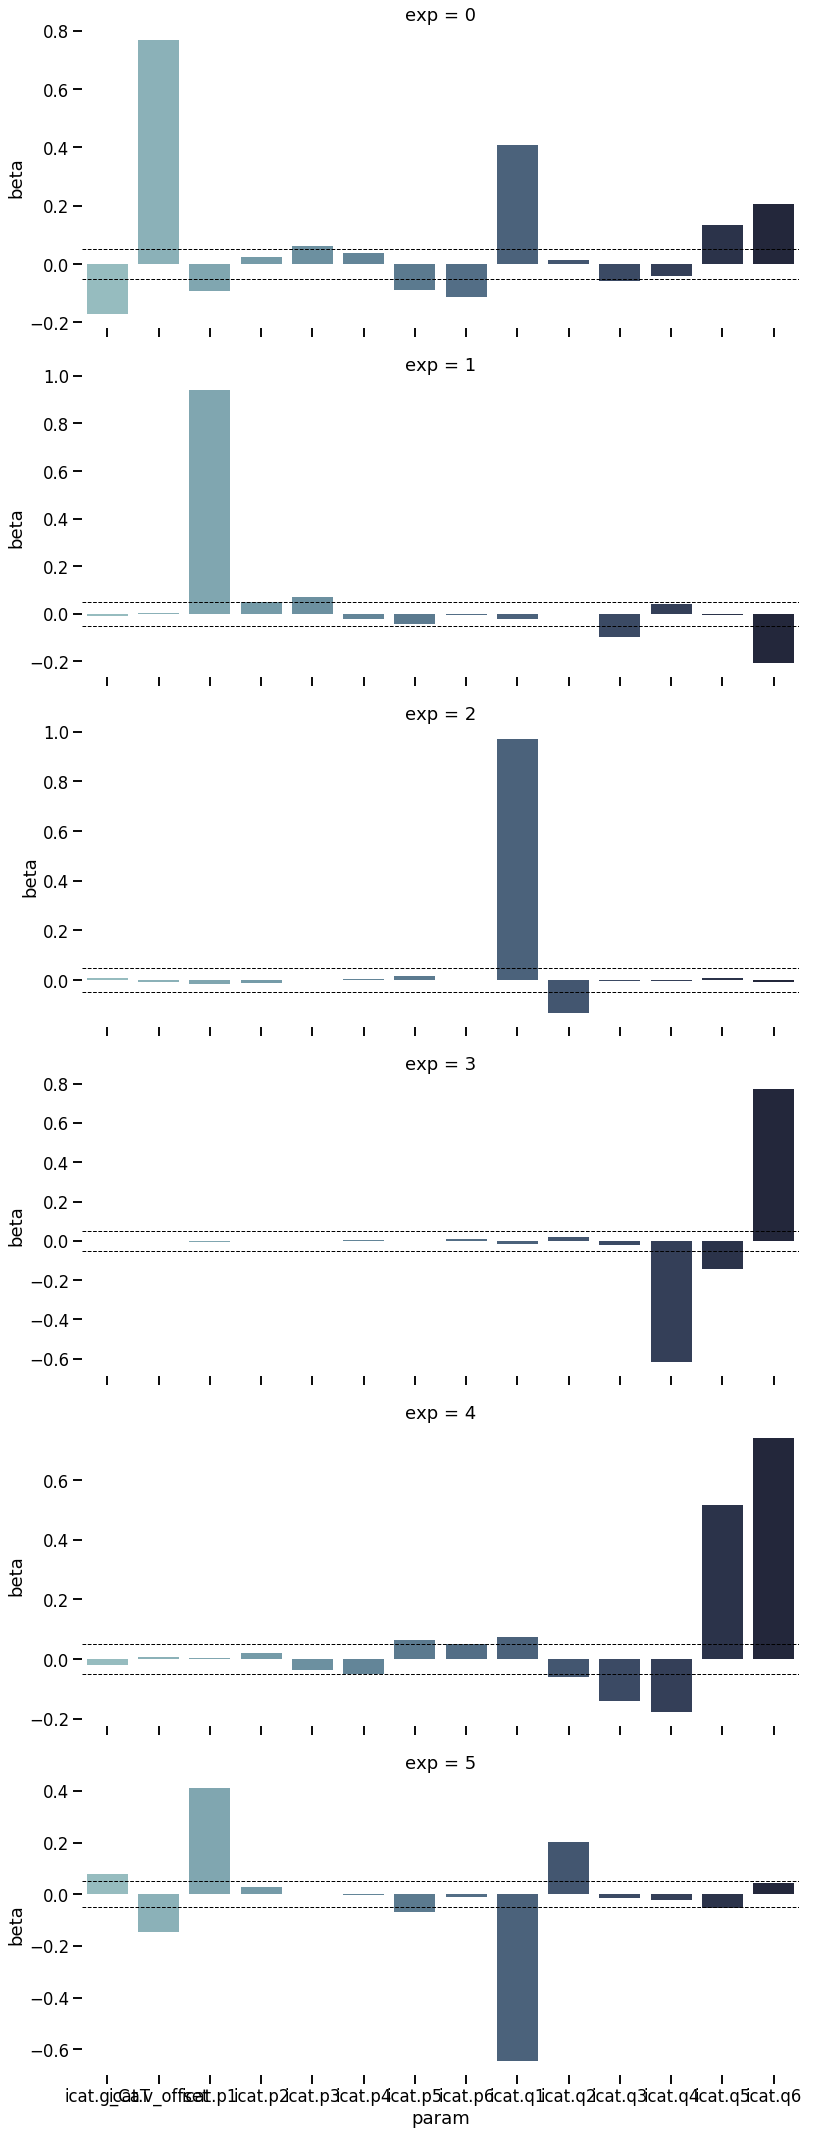

In [13]:
sns.set_context('talk')
grid = plot_parameter_sensitivity(fitted, plot_cutoff=0.05)

In [14]:
grid.savefig('results/icat/sensitivity.pdf')

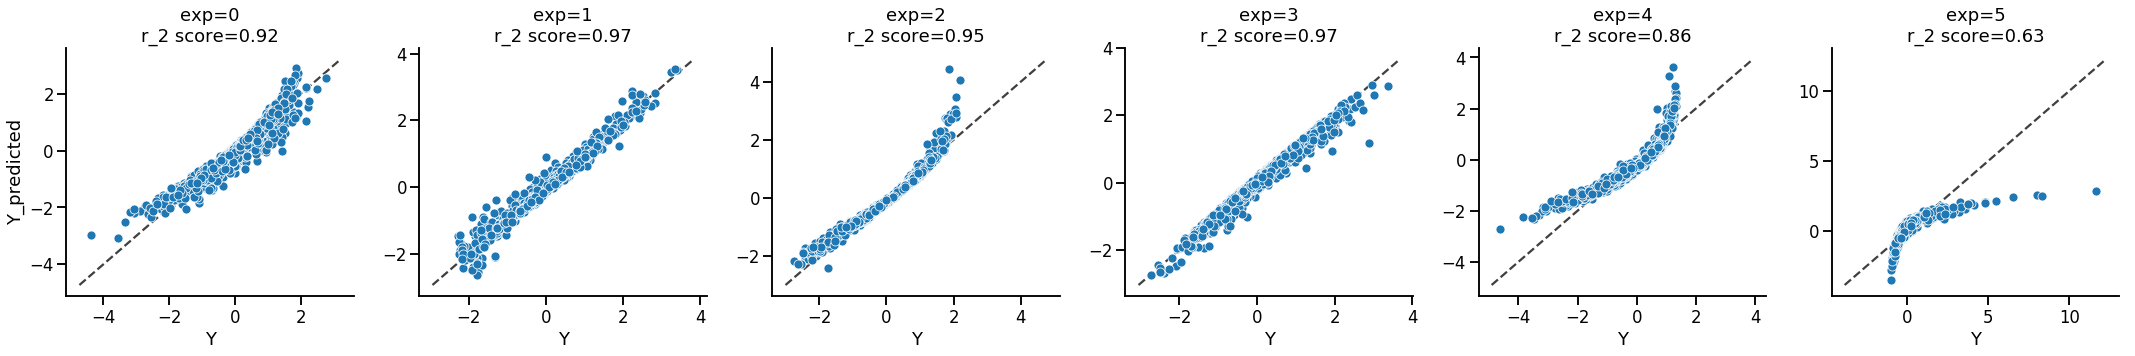

In [15]:
grid2 = plot_regression_fit(regression_fit, r2)

In [16]:
grid2.savefig('results/icat/sensitivity_fit.pdf')

# Weights of distance function

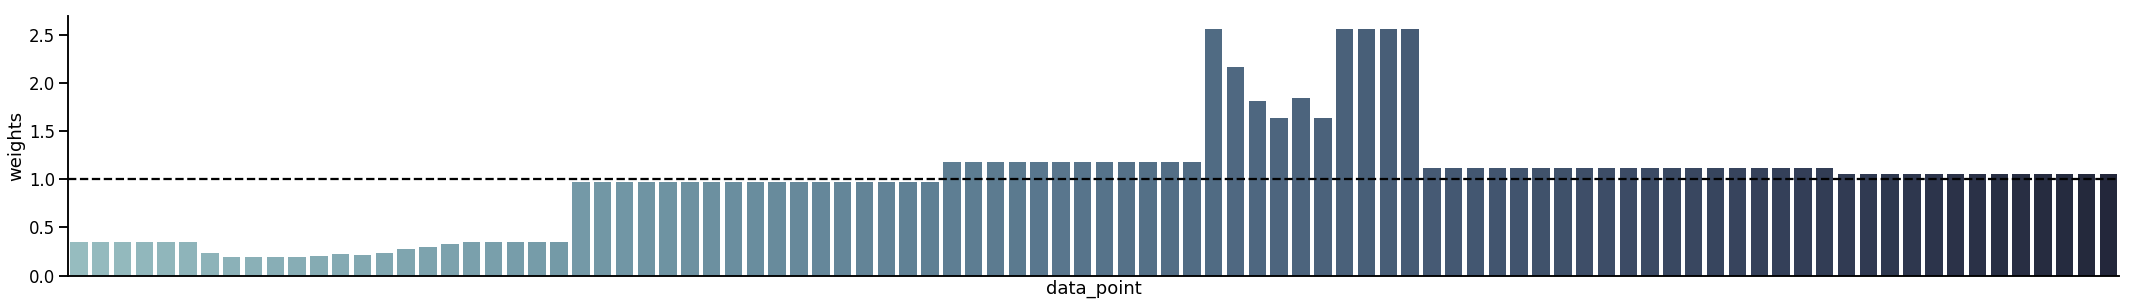

In [17]:
from ionchannelABC import plot_distance_weights
grid = plot_distance_weights(model, distance_fn)

In [18]:
grid.savefig('results/icat/dist_weights.pdf')

# Initialize pyabc database

In [19]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl-1_icat.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_icat.db


In [20]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [21]:
from pyabc.populationstrategy import ConstantPopulationSize

In [22]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             #population_size=ConstantPopulationSize(5000),
             population_size=AdaptivePopulationSize(
                 start_nr_particles=5000,
                 mean_cv=0.2,
                 max_population_size=5000,
                 min_population_size=100),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.3437158292831627, 1: 0.3437158292831627, 2: 0.3437158292831627, 3: 0.3437158292831627, 4: 0.3437158292831627, 5: 0.3437158292831627, 6: 0.23359946175355675, 7: 0.19709954585456368, 8: 0.19709954585456368, 9: 0.19709954585456368, 10: 0.19406724514910909, 11: 0.20345759572083993, 12: 0.22525662383378656, 13: 0.21023951557820128, 14: 0.23800699876777479, 15: 0.27422545510200186, 16: 0.30034216511171646, 17: 0.32344540858184795, 18: 0.3437158292831627, 19: 0.3437158292831627, 20: 0.3437158292831627, 21: 0.3437158292831627, 22: 0.3437158292831627, 23: 0.9694434159168854, 24: 0.9694434159168854, 25: 0.9694434159168854, 26: 0.9694434159168854, 27: 0.9694434159168854, 28: 0.9694434159168854, 29: 0.9694434159168854, 30: 0.9694434159168854, 31: 0.9694434159168854, 32: 0.9694434159168854, 33: 0.9694434159168854, 34: 0.9694434159168854, 35: 0.9694434159168854, 36: 0.9694434159168854, 37: 0.9694434159168854, 38: 0.9694434159168854, 39: 0.9694434159168854, 40: 1.

In [23]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=4, start_time=2018-11-02 09:30:05.098734, end_time=None)>
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:321: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = weighted_distances.distance.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:325: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  weights = weighted_distances.w.as_matrix()
INFO:Epsilon:initial epsilon is 117.60380741126777


In [ ]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=30, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:117.60380741126777
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 10223
DEBUG:Epsilon:new eps, t=1, eps=39.41271223679644
INFO:ABC:t:1 eps:39.41271223679644
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/smc.py:735: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.history.max_t)["p"].as_matrix()
INFO:Adaptatio

In [ ]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=30, min_acceptance_rate=0.01)

# Results analysis

In [8]:
history = History('sqlite:////scratch/cph211/ion-channel-ABC/docs/examples/results/icat/hl-1_icat.db')
#history = History('sqlite:////scratch/cph211/tmp/hl-1_icat.db')
#history = History('sqlite:////scratch/cph211/tmp/hl-1_icat-notau.db')
history.all_runs()

[<ABCSMC(id=1, start_time=2018-10-25 14:17:56.524918, end_time=None)>,
 <ABCSMC(id=2, start_time=2018-10-25 14:35:59.558058, end_time=None)>,
 <ABCSMC(id=3, start_time=2018-10-25 15:38:32.369806, end_time=2018-10-25 23:00:49.616887)>,
 <ABCSMC(id=4, start_time=2018-11-02 09:30:05.098734, end_time=2018-11-04 03:41:56.563964)>]

In [9]:
history.id = 4

In [10]:
sns.set_context('talk')

In [11]:
df, w = history.get_distribution(m=0)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


In [19]:
df.describe()

name,g_CaT,p1,p2,p3,p4,p5,p6,q1,q2,q3,q4,q5,q6,v_offset
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.597902,32.352268,4.300300,6.194084,4.945853,0.266352,291.046832,51.311668,1.992292,14.327029,131.647643,0.446165,38.788747,96.488868
std,0.038848,0.405446,0.129379,0.523005,2.672987,0.127060,108.961014,0.338983,0.129907,0.772263,6.797493,0.033616,0.739623,0.281633
min,0.489074,30.989017,3.883779,4.723127,0.000141,0.000017,5.837912,50.291156,1.595742,12.441286,112.996416,0.334321,36.519174,95.607079
25%,0.576241,32.071807,4.211734,5.879648,2.690793,0.164474,201.475077,51.071656,1.905211,13.772031,126.818849,0.422681,38.276511,96.287917
50%,0.602565,32.370105,4.299548,6.255668,4.915018,0.268825,289.418780,51.311251,1.995429,14.248266,131.442107,0.450719,38.826734,96.495471
75%,0.624216,32.636456,4.389550,6.545866,7.229559,0.369508,378.933758,51.548990,2.085144,14.802878,136.391658,0.472976,39.328210,96.691821
max,0.738862,33.508508,4.723349,8.036204,9.999005,0.499944,499.993476,52.287344,2.381190,16.948427,154.015117,0.499994,40.790767,97.366260


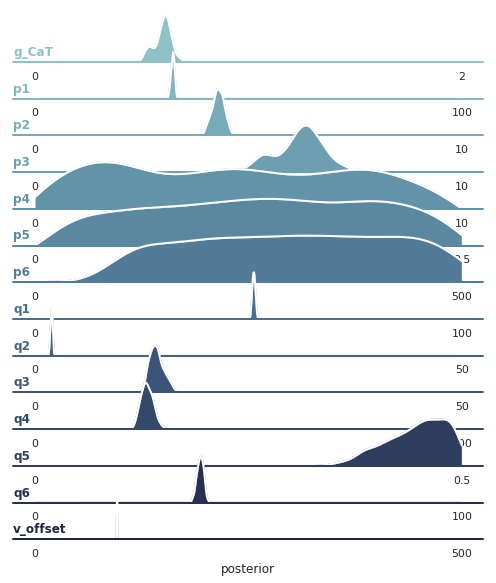

In [21]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits,aspect=12,height=0.6)

In [22]:
g.savefig('results/icat/parameters_kde.pdf')

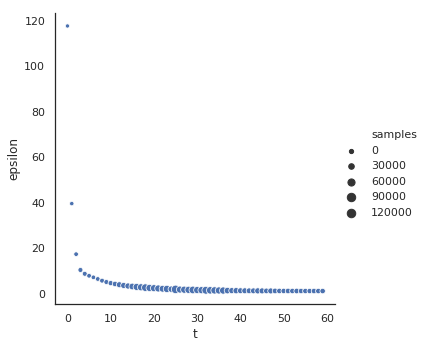

In [14]:
evolution = history.get_all_populations()
g = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
g.savefig('results/icat/eps_evolution.pdf')

# Samples for quantitative analysis

In [12]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [13]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

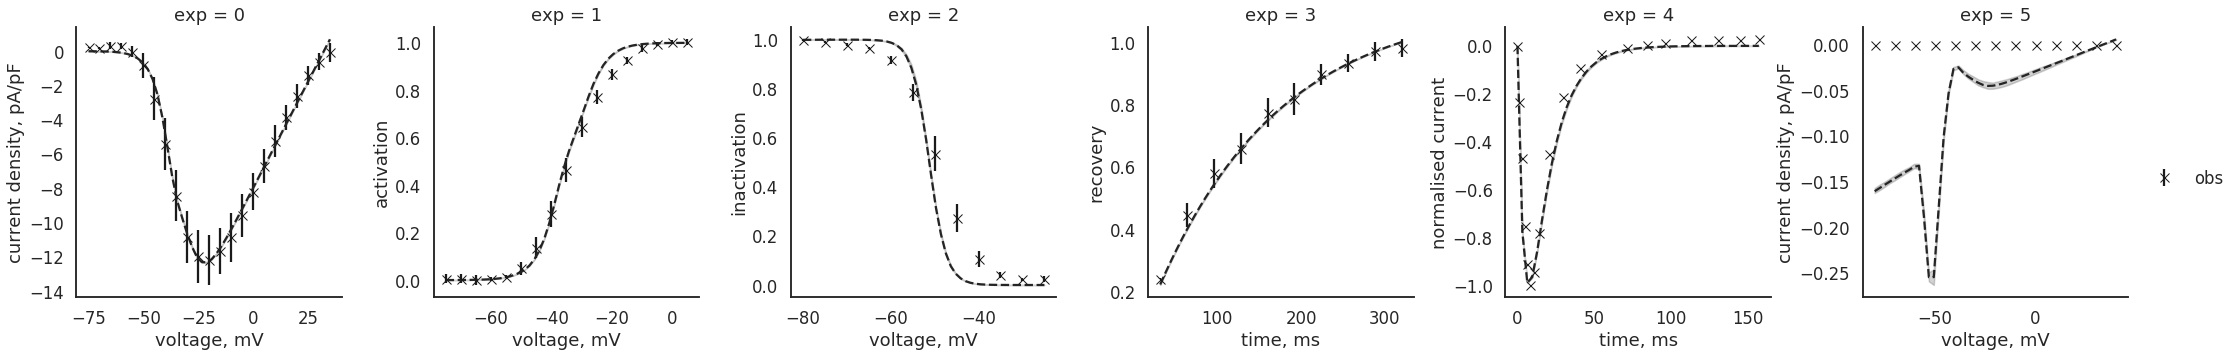

In [18]:
from ionchannelABC import plot_sim_results
sns.set_context('talk')
g = plot_sim_results(samples, obs=measurements)

# Set axis labels
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms", "time, ms","voltage, mV"]
ylabels = ["current density, pA/pF", "activation", "inactivation", "recovery", "normalised current","current density, pA/pF"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [19]:
g.savefig('results/icat/icat_sim_results.pdf')

In [20]:
# Mean current density
print(np.mean(samples[samples.exp==0].groupby('sample').min()['y']))
# Std current density
print(np.std(samples[samples.exp==0].groupby('sample').min()['y']))

-12.344614371895018
0.1115084561707785


In [21]:
import scipy.stats as st
peak_current = samples[samples['exp']==0].groupby('sample').min()['y'].tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))

In [22]:
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -12.33922789930232
95% CI: (-12.582955003938784, -12.14781048837616)


In [23]:
# Voltage of peak current density
idxs = samples[samples.exp==0].groupby('sample').idxmin()['y']
print("mean: {}".format(np.mean(samples.iloc[idxs]['x'])))
print("STD: {}".format(np.std(samples.iloc[idxs]['x'])))

mean: -21.908163265306122
STD: 1.0707480832231029


In [24]:
voltage_peak = samples.iloc[idxs]['x'].tolist()
rv = st.rv_discrete(values=(voltage_peak, [1/len(voltage_peak),]*len(voltage_peak)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -21.122448979591837
95% CI: (-23.367346938775512, -21.122448979591837)


In [25]:
# Half activation potential
# Fit of activation to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==1].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1/(1+np.exp((Vhalf-V)/K))
    guess = (-30, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [26]:
print(np.mean(output))
print(np.std(output))

0   -34.684616
1     5.195978
dtype: float64
0    0.212762
1    0.140072
dtype: float64


In [27]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -34.678626853093
95% CI: (-35.11822049549208, -34.30326864746186)


In [28]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 5.19109225713193
95% CI: (4.918366738086786, 5.470287009739208)


In [29]:
# Half activation potential
grouped = samples[samples['exp']==2].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1-1/(1+np.exp((Vhalf-V)/K))
    guess = (-100, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y,
                        bounds=([-100, 1], [0, 30]))
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [30]:
print(np.mean(output))
print(np.std(output))

0   -51.254806
1     1.972062
dtype: float64
0    0.321120
1    0.130504
dtype: float64


In [31]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -51.21101991809643
95% CI: (-51.89288555113618, -50.67016189258235)


In [32]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 1.9770266878315168
95% CI: (1.7086418978033322, 2.1938053181863446)


In [33]:
# Recovery time constant
grouped = samples[samples.exp==3].groupby('sample')
def fit_single_exp(group):
    def single_exp(t, I_max, tau):
        return I_max*(1-np.exp(-t/tau))
    guess = (1, 50)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt[1]
output = grouped.apply(fit_single_exp)

In [34]:
print(np.mean(output))
print(np.std(output))

146.48342625049057
6.977437273826417


In [35]:
tau = output.tolist()
rv = st.rv_discrete(values=(tau, [1/len(tau),]*len(tau)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 146.27857233664062
95% CI: (133.4937353106335, 160.83222601602338)
